In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [149]:
img = np.load(Path()/"spacio_training_2/validation_images/local_new_data.npy")
# img = np.load(Path()/"spacio_training_2/validation_images/local_bias_extended_20_epochs_remixed.npy")

geo = np.load(Path()/"spacio_training_2/processed/93_0_geom.npy")
mask = np.all(geo >= [0.003921569,0.003921569,0.003921569], axis=-1)
truth = np.load(Path()/"spacio_training_2/processed/93_U_0_2.npy")
truth[mask] = [0,0,0]
img[mask] = [0,0,0]

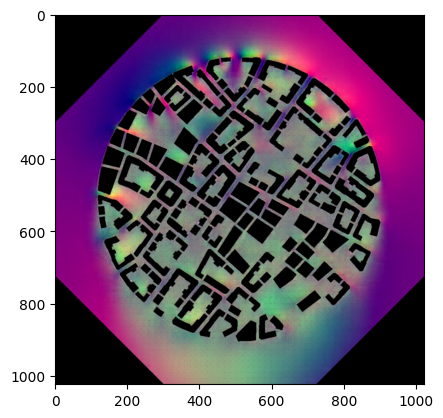

In [150]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


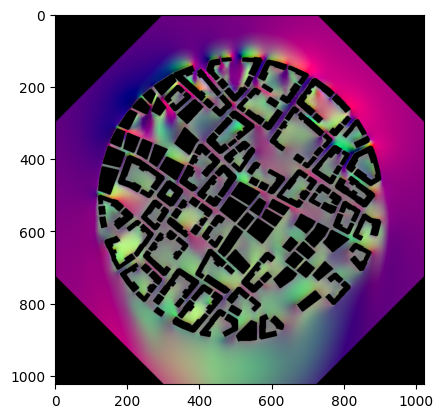

In [88]:
plt.imshow(truth)

In [151]:
# img = img[500:550, 450:500,:]
# truth = truth[501:551, 448:498,:]
diff = abs(truth - img)
ux = (diff[:,:,0])*6
uy = (diff[:,:,1])*4
uz = (diff[:,:,2])*2
mag = np.sqrt(ux**2 + uy**2 + uz**2)

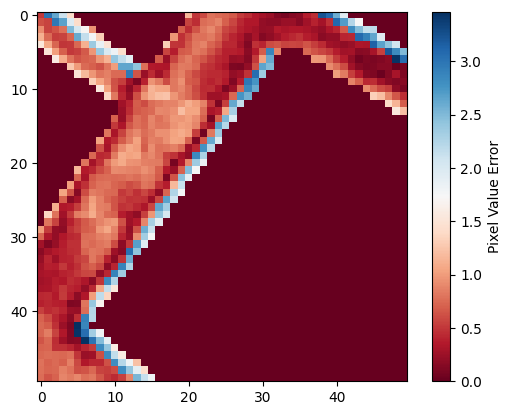

In [17]:
plt.imshow(mag[500:550, 450:500], cmap='RdBu')
plt.colorbar(label="Pixel Value Error")

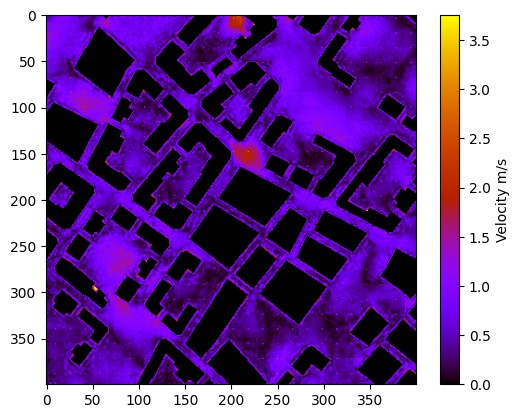

In [152]:
ux = (diff[:,:,0] * 6)-3
# ux[mask] = [0]
plt.imshow(mag[300:700,300:700], cmap='gnuplot')
plt.colorbar(label="Velocity m/s")
plt.savefig("Mag Velocity error.png")

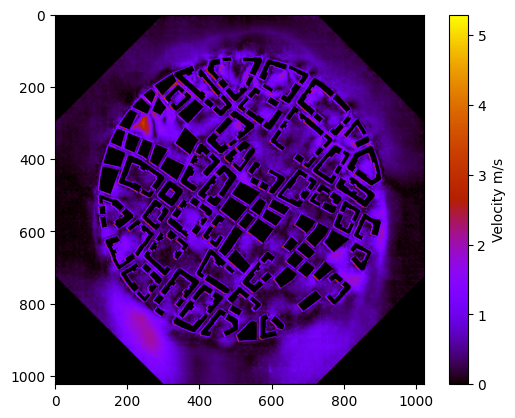

In [24]:
ux = (diff[:,:,0] * 6)-3
# ux[mask] = [0]
plt.imshow(mag, cmap='gnuplot')
plt.colorbar(label="Velocity m/s")
plt.savefig("Mag Velocity error.png")

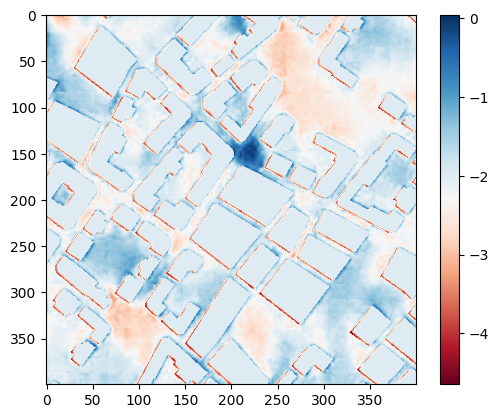

In [63]:
plt.imshow((diff[300:700,300:700,1]*4)-2, cmap='RdBu')
plt.colorbar()

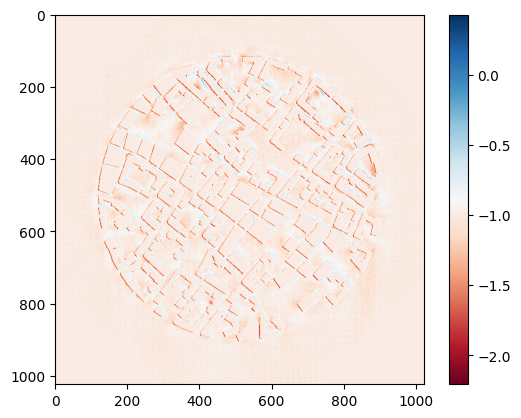

In [62]:
plt.imshow((diff[:,:,2]*2)-1, cmap='RdBu')
plt.colorbar()

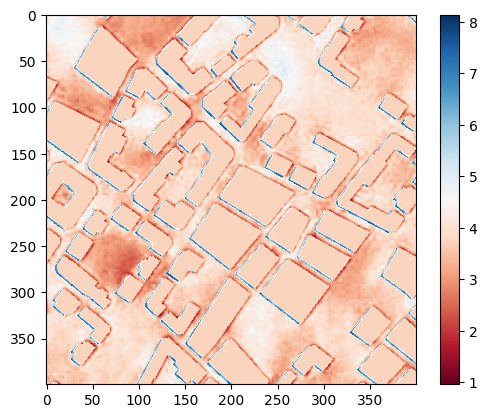

In [94]:
plt.imshow(mag[300:700, 300:700], cmap="RdBu")
plt.colorbar()

In [110]:
img_section = img[300:700, 300:700,:]
truth_section = truth[300:700, 300:700,:]

In [52]:
img_mag = np.sqrt(img_section[:,:,0]**2 + img_section[:,:,1]**2 + img_section[:,:,2]**2)
truth_mag = np.sqrt(truth_section[:,:,0]**2 + truth_section[:,:,1]**2 + truth_section[:,:,2]**2)

In [111]:
mask = np.all(truth_section <= [0.003921569,0.003921569,0.003921569], axis=-1)
mask = np.all(truth_mag == [0], axis=-1)

In [112]:
truth_section[mask] = [198,198,198]
img_section[mask] = [99,99,99]

In [55]:
truth_mag[mask] = [198]
img_mag[mask] = [99]

In [113]:
diff_section = truth_section - img_section

In [56]:
diff_mag = truth_mag - img_mag

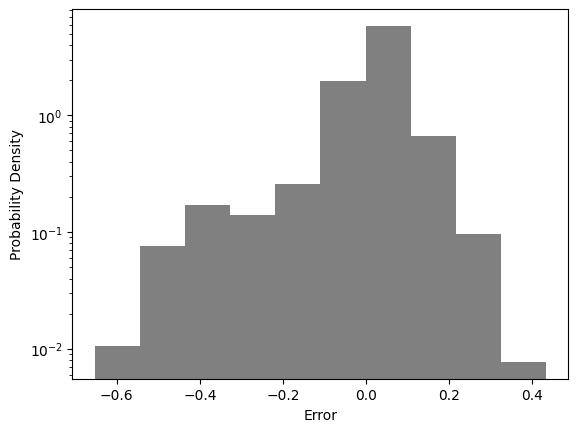

In [116]:
ux = diff_section[:,:,0]
plt.hist(ux[ux<99], log=True, density=True,color="grey")
plt.xlabel("Error")
plt.ylabel("Probability Density")
plt.savefig("plot.png")

In [ ]:
a = np.array([1.86421595e-03, 1.06506526e-01, 8.63835523e-01, 4.31200214e+00,
        3.21454142e+00, 9.19972983e-01, 1.81673146e-01, 3.10585412e-02,
        1.81145460e-02, 1.75869480e-03]),
b = np.array([-0.40083274, -0.29722005, -0.19360736, -0.08999468,  0.01361801,
         0.1172307 ,  0.22084339,  0.32445607,  0.42806876,  0.53168148,
         0.63529414])
b = np.diff(b)
a*b*100

In [ ]:
# 96.5% of data falls between -0.19 and 0.22
sum([8.95043136e+00, 4.46778141e+01,
        3.33067284e+01, 9.53208755e+00])

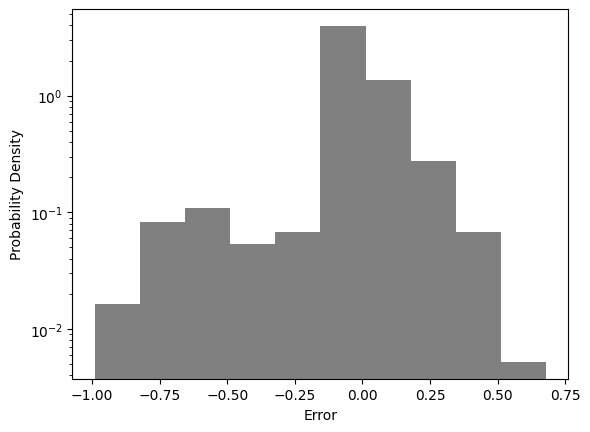

In [57]:
plt.hist(diff_mag[diff_mag<99], log=True, density=True,color="grey")
plt.xlabel("Error")
plt.ylabel("Probability Density")
plt.savefig("plot.png")

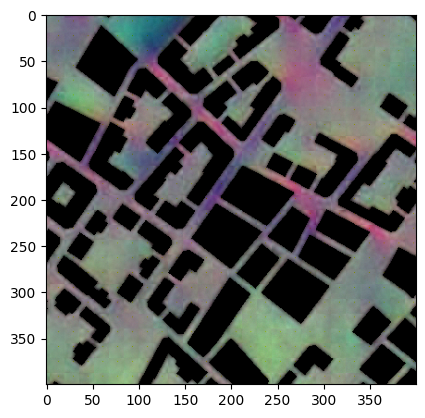

In [99]:
plt.imshow(img[300:700, 300:700,:])
plt.imsave("img_crop.png", img[300:700, 300:700,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


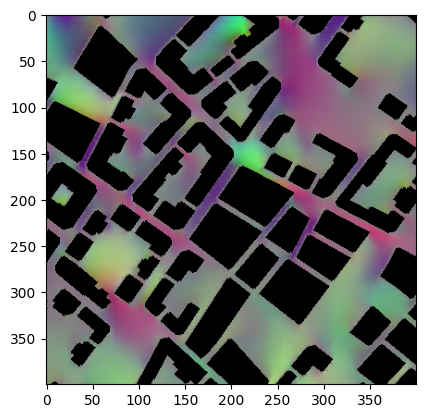

In [101]:
plt.imshow(truth[300:700, 300:700,:])
plt.imsave("truth_crop.png", truth[300:700, 300:700,:].clip(0,1))

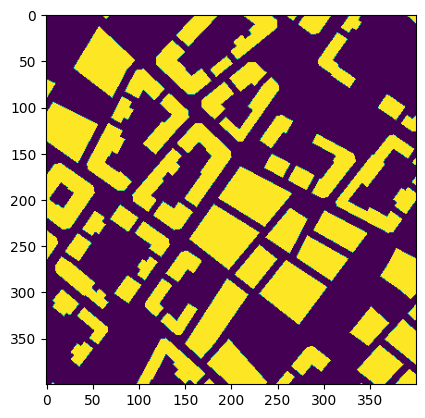

In [157]:
mag[mask] = [999]
mag = mag[300:700, 300:700]
plt.imshow(mag)

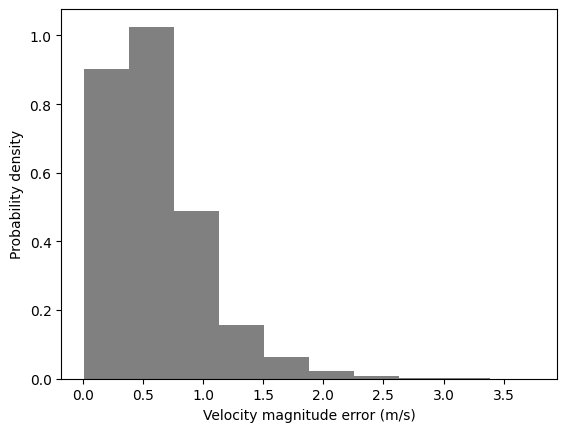

In [158]:
plt.hist(mag[mag<99], density=True, color="grey")
plt.xlabel("Velocity magnitude error (m/s)")
plt.ylabel("Probability density")
plt.savefig("Velocity_mag_error_pdf.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


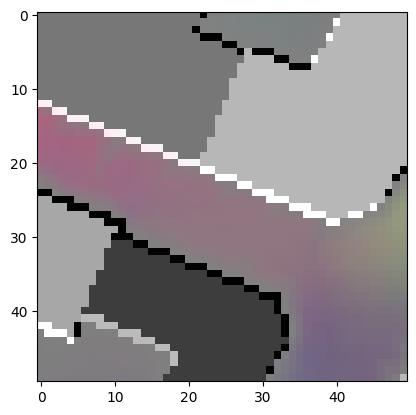

In [39]:
from pathlib import Path
path = Path("spacio_training_2")
a = plt.imread(path / f"spacio_training_2/0_U_0_0.png")
b = plt.imread(path / f"spacio_training_2/0_geom.png")
plt.imshow(geo[500:550, 450:500,:] + [500:550, 450:500,:])

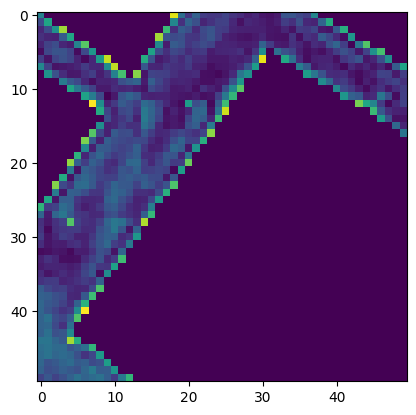

In [156]:
plt.imshow(mag[500:550, 450:500])